Assignment 1.2: Stats and visualization of the Rock Music Network

For this part of the assignment we have each developed our own version and compared the results at the end, improving our versions based on each other's feedback. The code and markdown presented in this notebook is from Denisa's version, however on each step alternative approaches from other group members are mentioned.

In order to create the network of Rock Musicians we have all started with creating the Regex expression that would find the content inside any [[]] link in the Wikipedia page.

Denisa's approach: Select the link with the | included.
Botond's approach: Select only the first part of the link, up until |.

In [2]:
wiki_pattern = '\[\[(.+?)\]\]'

Next, we download the list of Rock Musicians from Wikipedia with urllib.

In [3]:
import urllib
import re

title = 'List_of_mainstream_rock_performers'
url = "http://en.wikipedia.org/w/api.php?action=query&titles=%s&prop=revisions&rvprop=content&format=json" % title

req = urllib.request.Request(url, headers={'User-Agent' : "Magic Browser"}) 
con = urllib.request.urlopen(req)

source = con.read().decode('utf-8')


Then, we store all the links on the page.

In [4]:
wiki_links_artists = re.findall(wiki_pattern, source)

When going through the list of links, we found some which were not corresponding to artists.

Denisa's approach: Looking at the Wikipedia page, I noticed the first artist in the list is 10cc, while the last one is ZZ Top, so I have sliced the list to start from the index of the first artist to the index of the last one (+1 to add ZZ Top in the list too).

Botond's and Kyle's notes: When comparing our code, we realised that a link towards 'AllMusic' has to be removed too.

In [5]:
first_artist = wiki_links_artists.index('10cc')
last_artist = wiki_links_artists.index('ZZ Top')
wiki_links_artists = wiki_links_artists[first_artist:last_artist+1]
wiki_links_artists.remove('AllMusic')

In order to add the artist name inside the URL to request, the spaces inside the names had to be removed.

Denisa's approach: I replaced the spaces with '%20' since I noticed that is how the web browser does when entering the URL with the spaces in the search bar.

Botond's approach: Replace the spaces with underscores.

In [6]:
wiki_links_artists_to_parse = [x.replace(' ','%20') for x in wiki_links_artists] 

Then we went through each artist's name, get the content at the URL corresponding to the artist and save it in a file with the name of the artist.

The artist.replace('/', '_') deals with the cases such as AC/DC where the makedirs would create a file (DC) inside a folder (AC).

In [ ]:
import os

for artist in wiki_links_artists_to_parse:
    url = "http://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&format=json&titles=%s&rvslots=main" % artist
    req = urllib.request.Request(url, headers={'User-Agent' : "Magic Browser"}) 
    con = urllib.request.urlopen(req)
    source = con.read().decode('utf-8')

    # Change this according to the path you choose to save the files
    path = '/Volumes/MASTER/Year1/Social_graphs/artists'
    dir = path + '/%s.txt' % artist.replace('/', '_')
    os.makedirs(os.path.dirname(dir), exist_ok=True)
    with open(dir, 'w+') as file:
        file.write(source)

Having generated the files with the content of the pages, we continued by creating a graph where each node is an artist's name.

Notes from feedback: When we were comparing results (node count, edge count, adjacency matrices, in and out degrees, predecessors), we found an edge case for the band KISS. While in the list of performers it is present as Kiss (band)|Kiss, inside the content of the file of 3 Doors Down it is present as Kiss (band)|KISS. This led to the idea of using all the artist names in lowercase inside the nodes.

In [11]:
import networkx as nx

# Change every artist's name to lowercase
wiki_links_artists_lower = [artist.lower() for artist in wiki_links_artists]

network = nx.DiGraph()
network.add_nodes_from(wiki_links_artists_lower)

We then parsed the contents of each file to extract all the links it contained. Whenever a link matched a node in the graph (i.e., another rock artist), we added an edge from the artist represented by the current file to the artist referenced in the link.

During this step we also stored the length of the file content as an attribute of the node corresponding to the current file.

In [29]:
# Get all the files saved at the path
files = os.listdir(path)

# Parse every file
for i in range(len(files)):
    with open(path +'/'+ files[i], 'r') as f:
        text = f.read()
        # Get the total number of words
        word_count = len(re.findall(r"\w", text))
        # Store it as an attribute to the node corresponding to the current file
        nx.set_node_attributes(network, {wiki_links_artists_lower[i]: {'word_count': word_count}})
        # Find all the links in the file
        wiki_links_in_file = re.findall(wiki_pattern, text)
        # Parse each link
        for j in range(len(wiki_links_in_file)):
            try: 
                # If the link corresponds to another rock artist, add an edge from the artist represented by the current file to the artist referenced in the link
                # The check is done in lowercase letters.
                if wiki_links_in_file[j].lower() in wiki_links_artists_lower:
                    network.add_edge(wiki_links_artists_lower[i], wiki_links_in_file[j].lower())
            except:
                continue

We then discarded the isolated nodes using the NetworkX isolates function.

In [14]:
isolated = list(nx.isolates(network))
network.remove_nodes_from(isolated)

We then selected the largest component of the network by getting the maximum of the weakly connected components.

In [15]:
largest_component = max(nx.weakly_connected_components(network), key=len)

Regarding the following:
* Then, write a short section about which part of the process that was most difficult
* Next write a short section about how you used LLMs to help you
* Finally, compose a short section about what you would do differently if you had to do it again

Denisa answer: For me the most difficult part was creating the actual graph, making sure that I am correctly choosing the indices and creating the edges between the correct nodes. As for the LLM, I used it to check my Regex expression, look up how to access files and also how to visualise the graph with pyvis. I think if I would do it again I would try to write the network creation in a cleaner way. On first iteration I was more focused on making the process work, rather than the look of my code.

In the following section we describe the statistics and analysis of the network.

First we recreate the network from the information stored on Github.

In [97]:
import io

url = "https://raw.githubusercontent.com/denisababeii/socialgraphs_assignment1/refs/heads/denisa/network.graphml"

# Download the content of the raw file from Github with the network information
with urllib.request.urlopen(url) as response:
    data = response.read()

# Load directly into NetworkX
network = nx.read_graphml(io.BytesIO(data))

* The number of nodes

In [98]:
network.number_of_nodes()

484

* The number of edges

In [99]:
network.number_of_edges()

7655

* The in and out-degree distributions for the entire network.

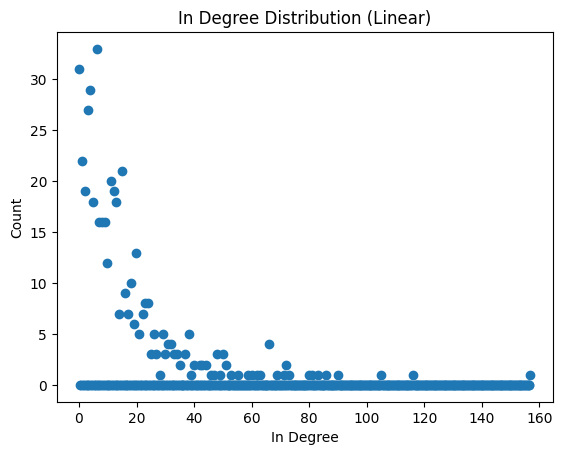

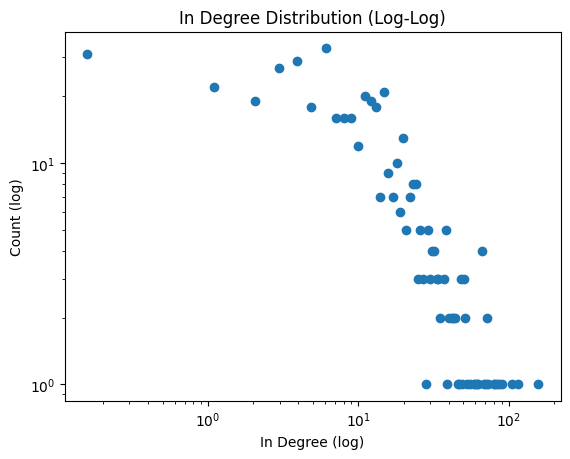

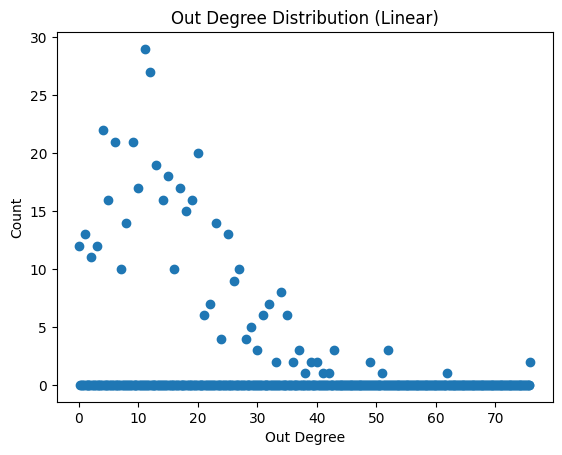

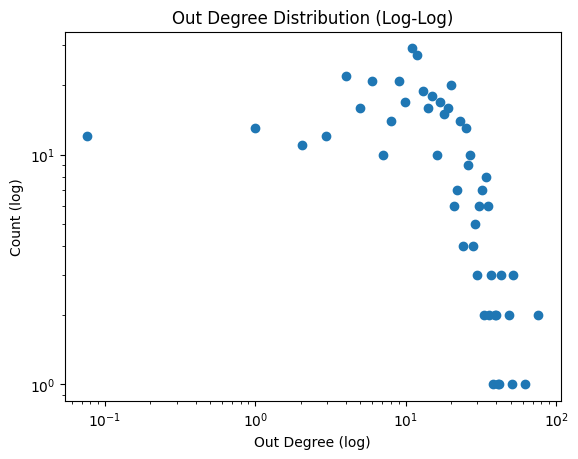

In [100]:
import numpy as np
import matplotlib.pyplot as plt

counts, bin_edges = np.histogram([deg for node, deg in network.in_degree()], 500)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.figure()
plt.plot(bin_centers, counts, 'o')
plt.xlabel('In Degree')
plt.ylabel('Count')
plt.title('In Degree Distribution (Linear)')
plt.show()

plt.figure()
plt.plot(bin_centers, counts, 'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('In Degree (log)')
plt.ylabel('Count (log)')
plt.title('In Degree Distribution (Log-Log)')
plt.show()

counts, bin_edges = np.histogram([deg for node, deg in network.out_degree()], 500)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.figure()
plt.plot(bin_centers, counts, 'o')
plt.xlabel('Out Degree')
plt.ylabel('Count')
plt.title('Out Degree Distribution (Linear)')
plt.show()

plt.figure()
plt.plot(bin_centers, counts, 'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Out Degree (log)')
plt.ylabel('Count (log)')
plt.title('Out Degree Distribution (Log-Log)')
plt.show()

The conclusions we have drawn from the plots are that most artists have low in degree, but a small number of artists are referenced by many others. This aligns with the expectation that only a few rock artists are famous enough to be heavily referenced. Out degree is smaller in range than the in degree, with fewer artists having very high out degree values. This means that a small amount of artists reference many others.

Comparing the out degree distribution to a random network with the same number of nodes and links, we can see the out degree for the random graph follows a normal distribution, while for the artists' network it follows a linear one.

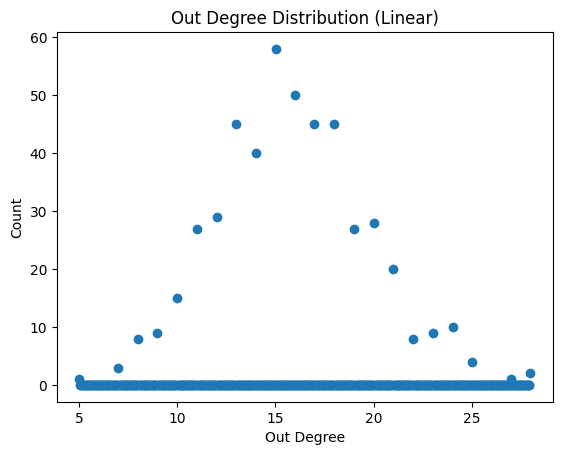

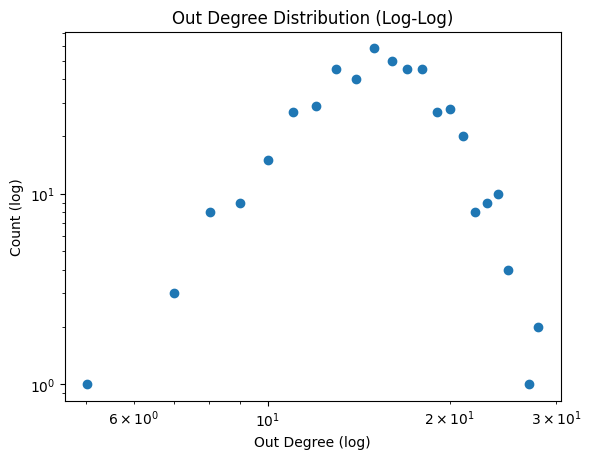

In [101]:
random_network = nx.gnm_random_graph(network.number_of_nodes(), network.number_of_edges(), 0, directed=True)

counts, bin_edges = np.histogram([deg for node, deg in random_network.out_degree()], 500)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.figure()
plt.plot(bin_centers, counts, 'o')
plt.xlabel('Out Degree')
plt.ylabel('Count')
plt.title('Out Degree Distribution (Linear)')
plt.show()

plt.figure()
plt.plot(bin_centers, counts, 'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Out Degree (log)')
plt.ylabel('Count (log)')
plt.title('Out Degree Distribution (Log-Log)')
plt.show()

Comparing the in degree distribution of a scale-free network with the same number of nodes, we can see the in degree for the scale-free graph is similar to the distribution of the in degree of the artists' network.

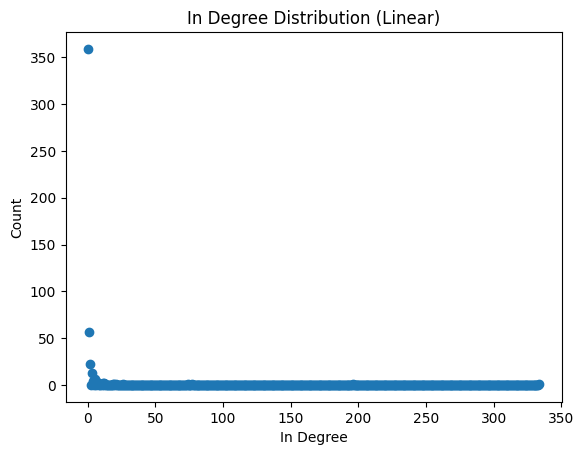

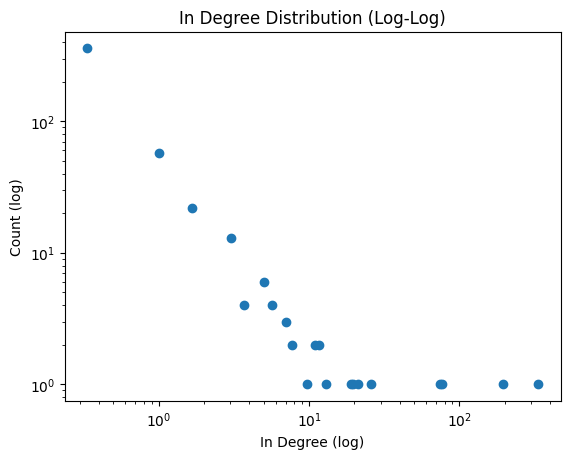

In [102]:
scale_free_network = nx.scale_free_graph(network.number_of_nodes())

counts, bin_edges = np.histogram([deg for node, deg in scale_free_network.in_degree()], 500)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.figure()
plt.plot(bin_centers, counts, 'o')
plt.xlabel('In Degree')
plt.ylabel('Count')
plt.title('In Degree Distribution (Linear)')
plt.show()

plt.figure()
plt.plot(bin_centers, counts, 'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('In Degree (log)')
plt.ylabel('Count (log)')
plt.title('In Degree Distribution (Log-Log)')
plt.show()

Computing the top 5 artists with the highest in degree, we can see highly influential artists in the list, as expected. The list does seem to showcase the artists we would predict.

In [104]:
top_5_in_degree_nodes = sorted(network.in_degree(), key=lambda x: x[1], reverse=True)[:5]
top_5_in_degree_nodes = [node for node, degree in top_5_in_degree_nodes]

top_5_in_degree_nodes

['the beatles',
 'led zeppelin',
 'the rolling stones',
 'bob dylan',
 'queen (band)|queen']

Computing the top 5 artists with the highest out degree, we can also see highly influential artists in the list. For the out degree we were not as sure about what to expect in terms of artists' names, as the amount of references an artist page has to others could depend on membership in many bands or collaborations.

In [105]:
top_5_out_degree_nodes = sorted(network.out_degree(), key=lambda x: x[1], reverse=True)[:5]
top_5_out_degree_nodes = [node for node, degree in top_5_out_degree_nodes]

top_5_out_degree_nodes

['alice in chains',
 'deep purple',
 'black sabbath',
 "guns n' roses",
 'queen (band)|queen']

* The 10 pages with the longest wiki entries

In [106]:
top_10_longest_content = sorted(network.nodes(data=True), key=lambda x: x[1]["word_count"], reverse=True)[:10]

top_10_longest_content

[('chicago (band)|chicago', {'word_count': 398604, 'size': 10}),
 ("guns n' roses", {'word_count': 287748, 'size': 10}),
 ('coldplay', {'word_count': 232078, 'size': 10}),
 ('europe (band)|europe', {'word_count': 229014, 'size': 10}),
 ('marilyn manson (band)', {'word_count': 228596, 'size': 10}),
 ('queen (band)|queen', {'word_count': 224581, 'size': 10}),
 ('ghost (swedish band)|ghost', {'word_count': 217596, 'size': 10}),
 ('boston (band)|boston', {'word_count': 215494, 'size': 10}),
 ('the rolling stones', {'word_count': 209840, 'size': 10}),
 ('oasis (band)|oasis', {'word_count': 208704, 'size': 10})]

In order to visualise the graph, we have converted it into an undirected graph.

In [107]:
undirected_network = network.to_undirected()

To plot according to the node degree and length of content, we saved these values in variables to input to the draw function.

In [108]:
node_degrees = [undirected_network.degree(node) for node in undirected_network.nodes()]
content_lengths = [node[1]['word_count'] for node in undirected_network.nodes(data=True)]

In order to create a color palette we used the green color map taking values between the minimum and maximum length of the files' contents.

In [109]:
cmap = plt.cm.Greens
norm = plt.Normalize(vmin=min(content_lengths), vmax=max(content_lengths))
node_colors = cmap(norm(content_lengths))

We used nx.spring_layout to draw the network, using the node degrees and the color palette created previously. We chose k=2 to better see the nodes with the highest degrees in center.

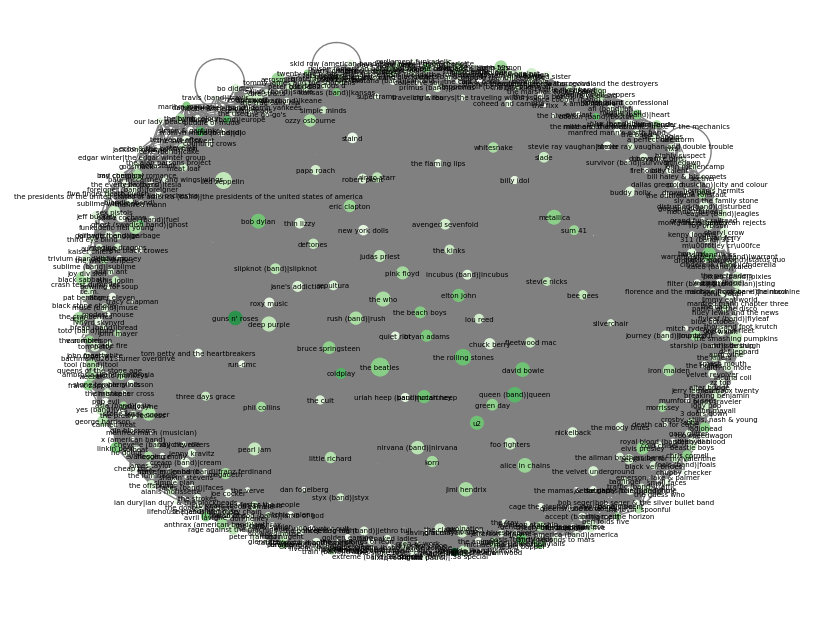

In [110]:
layout_spring = nx.spring_layout(undirected_network, k=2)  

# Draw graph
plt.figure(figsize=(8, 6))
nx.draw(
    undirected_network, layout_spring,
    with_labels=True,
    node_size=node_degrees,
    node_color=node_colors,
    font_size=5,
    edge_color="grey"
)
plt.show()

We were also exploring other options and came across pyvis. Below is the implementation for that, the graph looks nice though not really useful we would say. In order to see the graph you need to access the graph.html and wait for the network to load.

The cell below installs pyvis in the environment.

In [ ]:
!pip install pyvis

Then we create the graph.html with an interactive visualisation of the network.

In [ ]:
from pyvis.network import Network

# Convert to interactive Pyvis graph
net = Network(notebook=True, width="1000px", height="800px", bgcolor="#222222", font_color="white")
net.from_nx(network)

# Save and show
net.show("graph.html")